<a href="https://colab.research.google.com/github/Euler912/Thesis_Tools/blob/main/MDCF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install numpy scipy cvxpy

--- Solving Indefinite QCQP ---
D (Eigenvalues: [1. 1.])

Results:
Optimal x: [0.        0.7320508]
Max Value: 1.0000
Constraint Check (x'Qx <= 1): 0.5359 <= 1.0


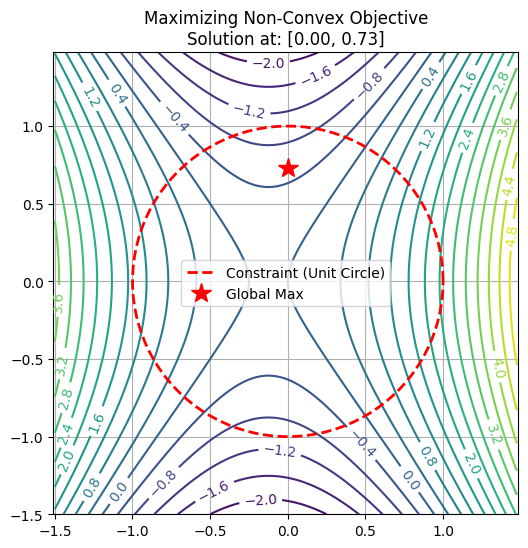

In [ ]:
import numpy as np
import cvxpy as cp
import scipy.linalg
import matplotlib.pyplot as plt

# --- Paste the hidden_convex function here or import it ---
def hidden_convex(D, x1, e, Q, q):
    # (Use the python code provided in the previous answer)
    D = np.array(D); Q = np.array(Q)
    x1 = np.array(x1).flatten(); e = np.array(e).flatten(); q = np.array(q).flatten()
    n1 = D.shape[0]
    L = scipy.linalg.cholesky(Q, lower=True)
    L_inv = scipy.linalg.inv(L)
    A = L_inv @ D @ L_inv.T
    alfa, U = scipy.linalg.eigh(A)
    S = L_inv.T @ U
    beta = S.T @ (D @ x1 - e)
    gamma = q.T @ Q @ q
    delta = -2 * S.T @ Q @ q

    y = cp.Variable(n1)
    z = cp.Variable(n1)
    objective = cp.Minimize(-alfa @ y + beta @ z)
    constraints = [2 * cp.sum(y) + delta @ z + gamma <= 1, 2 * y >= cp.square(z)]
    prob = cp.Problem(objective, constraints)
    prob.solve()

    z_val = z.value
    y_val = y.value
    gap = 2 * y_val - z_val**2
    if np.max(np.abs(gap)) > 1e-7:
        J = np.where(gap > 1e-7)[0]
        teta = 2 * y_val[J] + delta[J] * z_val[J]
        discriminant = delta[J]**2 + 4 * teta
        discriminant[discriminant < 0] = 0
        z_val[J] = 0.5 * (-delta[J] + np.sqrt(discriminant))
    x = S @ z_val
    diff = x - x1
    val_x = 0.5 * (diff.T @ D @ diff) + e.T @ diff
    return x, val_x
# ---------------------------------------------------------

# 1. Define the Matrices
D = [[1, 0],
     [0, 1]]   # Indefinite matrix (Saddle)
x1 = [0, 0]     # No offset in objective quadratic
e = [0, 1]    # Linear bias to the right
Q = [[2/3, 0],
     [0, 1/3]]    # Unit circle constraint (Identity)
q = [0, -1]      # Constraint centered at origin

print("--- Solving Indefinite QCQP ---")
print(f"D (Eigenvalues: {np.linalg.eigvals(D)})")

# 2. Run the Solver
optimal_x, max_val = hidden_convex(D, x1, e, Q, q)

# 3. Output Results
print("\nResults:")
print(f"Optimal x: {optimal_x}")
print(f"Max Value: {max_val:.4f}")

# 4. Verification
norm_sq = np.sum(optimal_x**2)
print(f"Constraint Check (x'Qx <= 1): {norm_sq:.4f} <= 1.0")

# 5. Visualizing the Result (Optional)
# This plots the saddle function contours and the circular constraint
delta = 0.025
x_range = np.arange(-1.5, 1.5, delta)
y_range = np.arange(-1.5, 1.5, delta)
X, Y = np.meshgrid(x_range, y_range)
# Objective function: 0.5*(4x^2 - 2y^2) + 0.5x
Z = 0.5 * (4*X**2 - 2*Y**2) + 0.5*X

plt.figure(figsize=(6,6))
# Plot Objective Contours
cs = plt.contour(X, Y, Z, levels=20, cmap='viridis')
plt.clabel(cs, inline=1, fontsize=10)
# Plot Constraint (Unit Circle)
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), 'r--', linewidth=2, label='Constraint (Unit Circle)')
# Plot Optimal Point
plt.plot(optimal_x[0], optimal_x[1], 'r*', markersize=15, label='Global Max')
plt.legend()
plt.title(f"Maximizing Non-Convex Objective\nSolution at: [{optimal_x[0]:.2f}, {optimal_x[1]:.2f}]")
plt.grid(True)
plt.axis('equal')
plt.show()

In [1]:
import numpy as np
import cvxpy as cp
import torch
import time


In [3]:

# 0. Global Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class MDCF_Solver:
    @staticmethod
    def compute_gradient(func, x, delta=1e-7):
        n = len(x)
        g = np.zeros(n)
        for i in range(n):
            e = np.zeros(n)
            e[i] = delta
            g[i] = (func(x + e) - func(x - e)) / (2 * delta)
        return g

    @staticmethod
    def hessian_fd(func, x, h=1e-5):
        n = len(x)
        H = np.zeros((n, n))
        for i in range(n):
            for j in range(i, n):
                x1, x2, x3, x4 = x.copy(), x.copy(), x.copy(), x.copy()
                x1[i] += h;
                x1[j] += h;
                x2[i] += h;
                x2[j] -= h
                x3[i] -= h;
                x3[j] += h;
                x4[i] -= h;
                x4[j] -= h
                val = (func(x1) - func(x2) - func(x3) + func(x4)) / (4 * h ** 2)
                H[i, j] = H[j, i] = val
        return H

    @staticmethod
    def hidden_convex_gpu(D_np, x1_np, e_np, Q_np, q_np):
        # 1. GPU Tensors
        D = torch.tensor(D_np, device=device, dtype=torch.float64)
        Q = torch.tensor(Q_np, device=device, dtype=torch.float64)
        x1 = torch.tensor(x1_np, device=device, dtype=torch.float64).view(-1, 1)
        e = torch.tensor(e_np, device=device, dtype=torch.float64).view(-1, 1)
        q = torch.tensor(q_np, device=device, dtype=torch.float64).view(-1, 1)

        # 2. GPU Linear Algebra
        L = torch.linalg.cholesky(Q)
        L_inv = torch.linalg.inv(L)
        A = L_inv @ D @ L_inv.T
        alfa, U = torch.linalg.eigh(A)
        S = L_inv.T @ U
        beta = S.T @ (D @ x1 - e)

        # 3. Data Cleaning for SCS
        alfa_np = np.ascontiguousarray(alfa.cpu().numpy().flatten())
        beta_np = np.ascontiguousarray(beta.cpu().numpy().flatten())
        delta_np = np.ascontiguousarray((-2 * S.T @ Q @ q).cpu().numpy().flatten())
        gamma_val = float((q.T @ Q @ q).item())

        y = cp.Variable(len(alfa_np));
        z = cp.Variable(len(alfa_np))
        prob = cp.Problem(cp.Minimize(-alfa_np @ y + beta_np @ z),
                          [2 * cp.sum(y) + delta_np @ z + gamma_val <= 1, 2 * y >= cp.square(z)])
        prob.solve(solver=cp.SCS)

        z_res = torch.tensor(z.value, device=device, dtype=torch.float64).view(-1, 1)
        return (S @ z_res).cpu().numpy().flatten()

    @staticmethod
    def solve(f_np, g_np, f_cp, g_cp, A_list, b_list, n):
        x_var = cp.Variable(n)
        constraints = [A @ x_var <= b for A, b in zip(A_list, b_list)]

        # --- Stage 1 ---
        cp.Problem(cp.Minimize(g_cp(x_var)), constraints).solve(solver=cp.SCS)
        x_g = x_var.value
        grad_g_at_xg = MDCF_Solver.compute_gradient(g_np, x_g)

        cp.Problem(cp.Minimize(f_cp(x_var) - grad_g_at_xg @ x_var), constraints).solve(solver=cp.SCS)
        x_hat = x_var.value

        H_f = MDCF_Solver.hessian_fd(f_np, x_hat)
        grad_f_hat = MDCF_Solver.compute_gradient(f_np, x_hat)
        x_mid = MDCF_Solver.hidden_convex_gpu(H_f, x_hat, grad_f_hat, np.eye(n) * 0.01, x_hat)

        x_curr = x_mid
        for _ in range(20):
            gf = MDCF_Solver.compute_gradient(f_np, x_curr)
            cp.Problem(cp.Maximize((gf - grad_g_at_xg) @ x_var), constraints).solve(solver=cp.SCS)
            if np.linalg.norm(x_var.value - x_curr) < 1e-5: break
            x_curr = x_var.value

        # --- Stage 2 ---
        x_dca = x_curr
        for k in range(50):
            gf_dca = MDCF_Solver.compute_gradient(f_np, x_dca)
            cp.Problem(cp.Maximize(gf_dca @ x_var - g_cp(x_var)), constraints).solve(solver=cp.SCS)
            x_new = x_var.value
            if np.linalg.norm(x_new - x_dca) < 1e-6: break
            x_dca = x_new

        return x_dca, (f_np(x_dca) - g_np(x_dca))


# --- Main Example Block ---# --- Execution ---
if __name__ == "__main__":
    n = 300
    print(f"Executing MDCF for n={n} | Objective: Maximize f(x) | Constraints: [-1/80, 2/80]")

    # f = (sum(x_i))^2 + 2*ln(sum(exp(x_i)))
    f_np = lambda x: (np.sum(x))**2 + sum(np.log(1+(np.exp(x))))
    g_np = lambda x: 0.0 # g is set to zero

    # CVXPY Definitions
    f_cp = lambda x: cp.square(cp.sum(x)) +   cp.sum(cp.logistic(x))
    g_cp = lambda x: 0.0 # g is set to zero

    # Constraints: x_i in [-1/80, 2/80]
    A = [np.vstack([np.eye(n), -np.eye(n)])]
    b = [np.concatenate([np.ones(n) * (2/80), np.ones(n) * (1/80)])]

    start_time = time.time()
    x_opt, val = MDCF_Solver.solve(f_np, g_np, f_cp, g_cp, A, b, n)
    end_time = time.time()

    print("-" * 40)
    print(f"Optimal Value (f-0): {val:.10f}")
    print(f"Time Taken: {end_time - start_time:.2f}s")
    print(f"Optimal x (first 5): {x_opt[:5]}")

Executing MDCF for n=300 | Objective: Maximize f(x) | Constraints: [-1/80, 2/80]
----------------------------------------
Optimal Value (f-0): 267.9675910611
Time Taken: 13.20s
Optimal x (first 5): [0.025 0.025 0.025 0.025 0.025]
